# Project Outline: Finding Similar Job Summaries Using MinHash and LSH

## Objective
- Analyze job descriptions to identify similar summaries using MinHash and Locality-Sensitive Hashing (LSH).
- Provide an efficient, scalable method to group similar job summaries based on textual similarity.

## Dataset
- **Source**: Kaggle Dataset "1.3M LinkedIn Jobs and Skills 2024."
- **Format**: CSV file containing job summaries.
- **Subset**: Limited to 500 rows for testing and scalability.

## Workflow
1. **Environment Setup**
   - Initialize dependencies and Spark session.
   - Download and load the dataset.

2. **Data Preprocessing**
   - Remove duplicates and clean the text (e.g., HTML tags, URLs, punctuation, etc.).
   - Tokenize text and remove stopwords.

3. **Feature Engineering**
   - Generate shingles (2-grams) for job summaries.
   - Create sparse vector representations of shingles using `HashingTF`.

4. **MinHash and LSH Implementation**
   - Compute MinHash signatures for each document.
   - Apply LSH banding to group documents into candidate pairs.

5. **Candidate Pair Identification**
   - Self-join on LSH bands to identify pairs of job summaries sharing bands.
   - Filter duplicate and self-pairs.

6. **Similarity Evaluation**
   - Compute Jaccard similarity for candidate pairs.
   - Filter pairs based on a similarity threshold.

7. **Visualization and Insights**
   - Plot distribution of Jaccard similarities.
   - Analyze the frequency of shingles.

## Deliverables
- A list of job summary pairs with high similarity scores.
- Visualizations (e.g., Jaccard similarity distribution, shingle frequency).
- Code implementation demonstrating scalability and efficiency.

## Future Enhancements
- Scale the analysis to the full dataset.
- Experiment with alternative similarity metrics (e.g., Cosine Similarity).
- Automate pipeline using Spark MLlib.

## Usage
- Run the script sequentially to preprocess the dataset, generate candidate pairs, and evaluate similarity.
- Adjust parameters (e.g., similarity thresholds, number of bands) to fine-tune results.


# Environment Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install necessary libraries
!pip install kaggle
!pip install findspark
!pip install pyspark

In [3]:
import os

# Set Kaggle credentials
os.environ['KAGGLE_USERNAME'] = "emilsoltanov"
os.environ['KAGGLE_KEY'] = "79f7a2985b5574514188ad0da4dcf076"

In [4]:
# Download the dataset
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 --unzip
!ls

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 99% 1.86G/1.88G [00:23<00:00, 80.8MB/s]
100% 1.88G/1.88G [00:23<00:00, 86.9MB/s]
drive  job_skills.csv  job_summary.csv	linkedin_job_postings.csv  sample_data


In [5]:
# Initialize Spark Session
from pyspark.sql import SparkSession

# Configure Spark with optimized memory and processing settings
spark = SparkSession.builder \
    .appName("JobSimilarity") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "4") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext  # Get the SparkContext

# Load the Dataset

In [6]:
# Load job summaries into a DataFrame
df = spark.read.csv("job_summary.csv", header=True, inferSchema=True, multiLine=True, escape='"') \
    .select("job_summary")

In [7]:
# Limit the dataset for testing
df = df.limit(500)

# Repartition for better scalability
df = df.repartition(20)

# Preview the dataset
df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data Preprocessing

In [8]:
from pyspark.sql.functions import col
# Drop duplicate rows based on job_summary
df = df.dropDuplicates(['job_summary'])

# Remove rows with null or empty job_summary values
df = df.filter(col("job_summary").isNotNull() & (col("job_summary") != ""))

# Show the cleaned data
df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Text Cleaning

In [9]:
from pyspark.sql.functions import col, udf, size, lower
from pyspark.sql.types import ArrayType, StringType
import re

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text.strip())

# Register cleaning functions as UDFs
html_udf = udf(remove_html_tags, StringType())
url_udf = udf(remove_url, StringType())
non_ascii_udf = udf(remove_non_ascii, StringType())
numbers_udf = udf(remove_numbers, StringType())
punctuation_udf = udf(remove_punctuation, StringType())
spaces_udf = udf(remove_extra_spaces, StringType())

df = df.withColumn("job_summary", lower(col("job_summary"))) \
       .withColumn("job_summary", html_udf(col("job_summary"))) \
       .withColumn("job_summary", url_udf(col("job_summary"))) \
       .withColumn("job_summary", non_ascii_udf(col("job_summary"))) \
       .withColumn("job_summary", numbers_udf(col("job_summary"))) \
       .withColumn("job_summary", punctuation_udf(col("job_summary"))) \
       .withColumn("job_summary", spaces_udf(col("job_summary")))

df = df.dropDuplicates(['job_summary'])
df = df.filter(col("job_summary").isNotNull() & (col("job_summary") != ""))

# Tokenization and Stopword Removal

In [10]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Tokenize the job summaries
tokenizer = Tokenizer(inputCol="job_summary", outputCol="words")
df = tokenizer.transform(df)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Generate Shingles

In [11]:
from pyspark.sql.functions import size, array
from pyspark.sql.types import ArrayType

def generate_shingles(words, k=2):
    return [' '.join(words[i:i + k]) for i in range(len(words) - k + 1)]

# Register UDF for shingles
shingle_udf = udf(lambda words: generate_shingles(words, k=2), ArrayType(StringType()))

# Apply UDF to generate trigrams
df = df.withColumn("shingles", shingle_udf(col("filtered_words")))
df = df.filter(size(col("shingles")) > 0)

# Show cleaned and processed data
df.select("shingles").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Sparse Vector Representation

In [12]:
from pyspark.ml.feature import HashingTF

# Create sparse vectors with HashingTF
hashingTF = HashingTF(inputCol="shingles", outputCol="features", numFeatures=1000)
df = hashingTF.transform(df)

# Apply MinHashLSH (custom functions)

## Custom MinHash

In [13]:
# Custom MinHash
import numpy as np
from pyspark.sql.functions import udf, lit, when, size, col, array_repeat
from pyspark.sql.types import ArrayType, IntegerType

def generate_hash_functions(num_hashes, max_shingles):
    hash_functions = []
    # Generate hash functions with pre-computed parameters
    for i in range(num_hashes):
        a = np.random.randint(1, max_shingles)
        b = np.random.randint(1, max_shingles)
        # Create a function with a, b, p, and m bound as constants
        hash_functions.append(lambda x, a=a, b=b, p=100003, m=max_shingles: (a * x + b) % p % m)
    return hash_functions

def minhash(shingles, num_hashes=100, max_shingles=1000):
    if not shingles:
        return [max_shingles] * num_hashes
    signatures = []
    hash_functions = generate_hash_functions(num_hashes, max_shingles)
    for h in hash_functions:
        min_hash = min(h(hash(shingle)) for shingle in shingles)
        signatures.append(min_hash)
    return signatures

# UDF for MinHashing
minhash_udf = udf(lambda shingles: minhash(shingles), ArrayType(IntegerType()))

# Apply MinHashing to generate signatures
num_hashes = 50
df = df.withColumn("minhash_signature", minhash_udf(col("shingles")))

# Use lit to convert constant value to a column
max_shingles = 1000
df = df.withColumn("minhash_signature", when(size(col("minhash_signature")) == 0, array_repeat(lit(max_shingles), num_hashes)).otherwise(col("minhash_signature")))

df.select("minhash_signature").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|minhash_signature                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1, 8, 4, 6, 1, 2, 3, 0, 3, 6, 4, 7, 0, 0, 3,

## Custom LSH

In [14]:
# Custom LSH
def lsh_banding(signature, num_bands=20):
    rows_per_band = len(signature) // num_bands
    bands = []
    for i in range(num_bands):
        start = i * rows_per_band
        end = start + rows_per_band
        bands.append(hash(tuple(signature[start:end])))
    return bands

# UDF for LSH Banding
lsh_banding_udf = udf(lambda signature: lsh_banding(signature, num_bands=20), ArrayType(IntegerType()))

# Apply LSH Banding
num_bands = 10
df = df.withColumn("lsh_bands", lsh_banding_udf(col("minhash_signature")))
df.select("lsh_bands").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|lsh_bands                                                                                                                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-664258653, 24449618, 1510622570, -866319934, 1111341919, -1019244817, -1925718487, -1492310121, -851631438, -67043331, 1677056066, -1965475645, -959028979, 1417037280, 1048358695, -1479170756, -461158065, -22925571, -1659196381, 1289687926]  |
|[-825692368

# Candidate Pair Identification

In [15]:
# Candidate Pair Identification
from pyspark.sql.functions import explode

# Explode bands into separate rows
exploded_df = df.withColumn("band", explode(col("lsh_bands")))

# Self-join on band values to find candidate pairs
candidate_pairs = exploded_df.alias("a").join(
    exploded_df.alias("b"),
    col("a.band") == col("b.band"),
).filter(
    col("a.job_summary") != col("b.job_summary")
)

# Remove duplicate pairs (e.g., A-B and B-A)
candidate_pairs = candidate_pairs.filter(col("a.job_summary") < col("b.job_summary"))

# Show candidate pairs
candidate_pairs.select(
    col("a.job_summary").alias("job_summary_1"),
    col("b.job_summary").alias("job_summary_2"),
    col("a.band").alias("common_band")
).show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Evaluation of Candidate Pairs

In [16]:
# Evaluation of Candidate Pairs
from pyspark.sql.types import FloatType

# Evaluation of Candidate Pairs
def jaccard_similarity(set1, set2):
    intersection = len(set(set1) & set(set2))
    union = len(set(set1) | set(set2))
    return intersection / union if union != 0 else 0.0

jaccard_udf = udf(lambda x, y: jaccard_similarity(x, y), FloatType())

# Add Jaccard Similarity to candidate pairs
candidate_pairs = candidate_pairs.withColumn(
    "jaccard_similarity",
    jaccard_udf(col("a.shingles"), col("b.shingles"))
).filter(col("jaccard_similarity") > 0.6)

# Show final similar pairs
candidate_pairs.select(
    col("a.job_summary").alias("job_summary_1"),
    col("b.job_summary").alias("job_summary_2"),
    col("jaccard_similarity")
).orderBy("jaccard_similarity", ascending=False).show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique IDs to each job summary
df = df.withColumn("job_id", monotonically_increasing_id())

# Use IDs for both job summaries in candidate pairs
candidate_pairs = candidate_pairs \
    .join(df.alias("df1"), col("a.job_summary") == col("df1.job_summary")) \
    .join(df.alias("df2"), col("b.job_summary") == col("df2.job_summary")) \
    .select(
        col("df1.job_id").alias("Job ID 1"),
        col("df2.job_id").alias("Job ID 2"),
        col("jaccard_similarity")
    ).distinct()

# Display the top 10 results by Jaccard Similarity
candidate_pairs.orderBy("jaccard_similarity", ascending=False).show(10, truncate=False)

+--------+--------+------------------+
|Job ID 1|Job ID 2|jaccard_similarity|
+--------+--------+------------------+
|2       |25      |0.9921363         |
|64      |168     |0.9648562         |
|154     |69      |0.95533496        |
|119     |345     |0.9295238         |
+--------+--------+------------------+



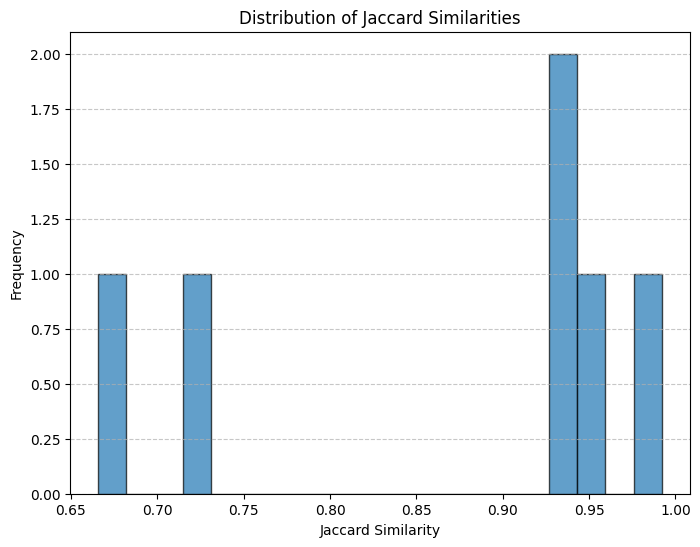

In [18]:
import matplotlib.pyplot as plt

# Collect Jaccard distances
jaccard_distances = (
    candidate_pairs.select("jaccard_similarity")
    .rdd.flatMap(lambda x: x)
    .collect()
)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(jaccard_distances, bins=20, edgecolor="black", alpha=0.7)
plt.title("Distribution of Jaccard Similarities")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Top Similar Document Pairs

In [19]:
# Top Similar Document Pairs
top_similar_pairs = (
    candidate_pairs.orderBy("jaccard_similarity", ascending=False)
    .select("Job ID 1", "Job ID 2", "jaccard_similarity")
    .limit(10)
    .collect()
)

# Print the results
for i, row in enumerate(top_similar_pairs, 1):
    print(f"Pair {i}:")
    print(f" - Document A: {row['Job ID 1']}")
    print(f" - Document B: {row['Job ID 2']}")
    print(f" - Jaccard Similarity: {row['jaccard_similarity']:.4f}\n")

Pair 1:
 - Document A: 89
 - Document B: 94
 - Jaccard Similarity: 0.9943

Pair 2:
 - Document A: 2
 - Document B: 25
 - Jaccard Similarity: 0.9921

Pair 3:
 - Document A: 179
 - Document B: 243
 - Jaccard Similarity: 0.9863

Pair 4:
 - Document A: 66
 - Document B: 136
 - Jaccard Similarity: 0.9533

Pair 5:
 - Document A: 169
 - Document B: 247
 - Jaccard Similarity: 0.9504

Pair 6:
 - Document A: 231
 - Document B: 325
 - Jaccard Similarity: 0.9286

Pair 7:
 - Document A: 244
 - Document B: 196
 - Jaccard Similarity: 0.9051

Pair 8:
 - Document A: 165
 - Document B: 136
 - Jaccard Similarity: 0.8266

Pair 9:
 - Document A: 341
 - Document B: 102
 - Jaccard Similarity: 0.7217

Pair 10:
 - Document A: 95
 - Document B: 229
 - Jaccard Similarity: 0.6658



# Shingle Frequency

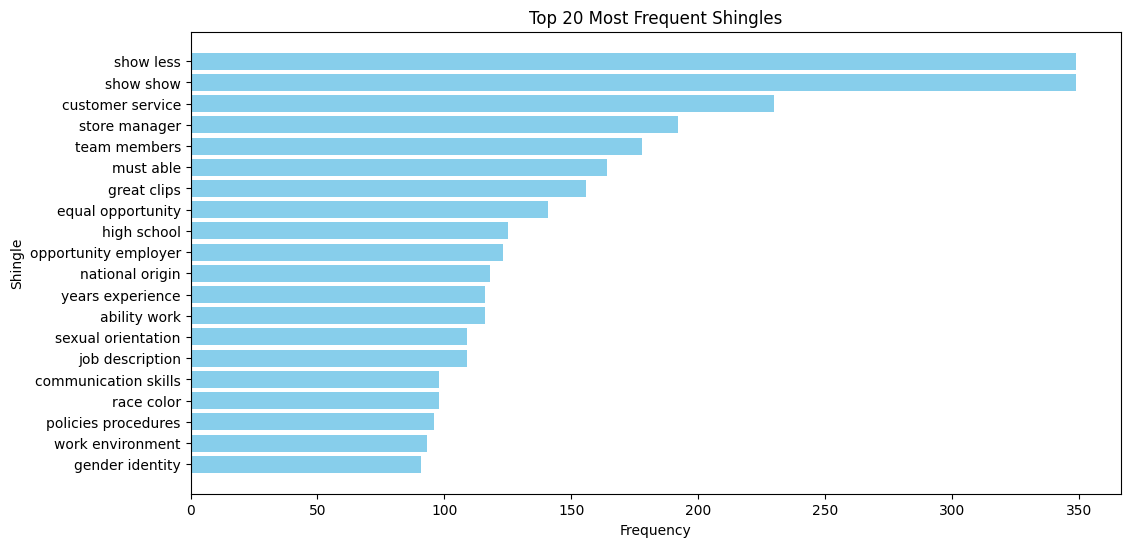

In [20]:
# Flatten the shingles and count occurrences
from pyspark.sql.functions import explode

shingle_counts = (
    df.select(explode("shingles").alias("shingle"))
    .groupBy("shingle")
    .count()
    .orderBy("count", ascending=False)
    .limit(20)  # Top 20 shingles
)

# Collect for visualization
shingle_data = shingle_counts.collect()
shingles = [row["shingle"] for row in shingle_data]
counts = [row["count"] for row in shingle_data]

# Bar plot for shingle frequency
plt.figure(figsize=(12, 6))
plt.barh(shingles, counts, color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Shingle")
plt.title("Top 20 Most Frequent Shingles")
plt.gca().invert_yaxis()
plt.show()

# False Positive and Negative Probabilities

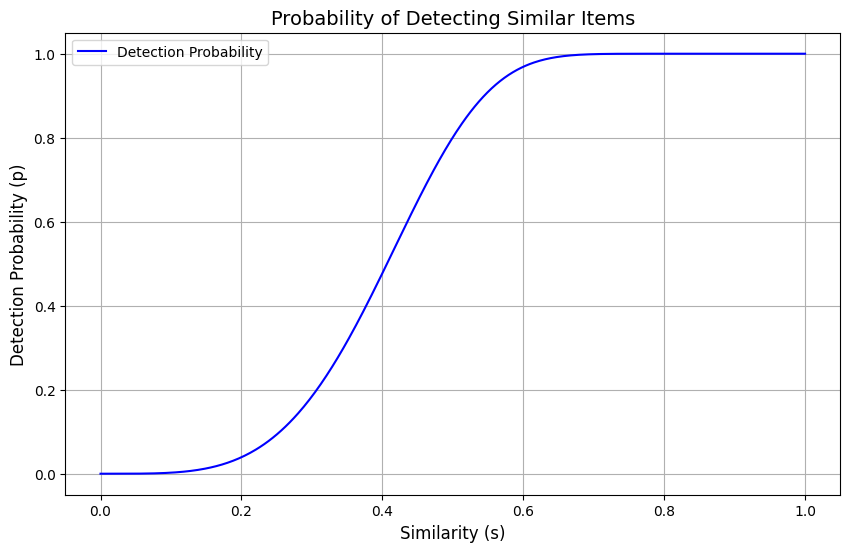

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
s = np.linspace(0, 1, 500)  # Similarity thresholds
r = 4  # Number of rows
b = 25  # Number of bands

# Detection probability formula
p = 1 - (1 - s**r)**b

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s, p, label="Detection Probability", color='b')
plt.title('Probability of Detecting Similar Items', fontsize=14)
plt.xlabel('Similarity (s)', fontsize=12)
plt.ylabel('Detection Probability (p)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()